In [2]:
# Import Libraries.

import os
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
import pylab
import itertools
from wordcloud import WordCloud
from hmmlearn import hmm
import datetime as dt
import graphviz
from graphviz import Source
import networkx as nx
import pydotplus
from IPython.display import Image 
import sklearn
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.covariance import empirical_covariance
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.externals.six import StringIO 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.utils.fixes import signature
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
from skater.util.logger import _INFO

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import rc
from matplotlib.ticker import FormatStrFormatter
import pandas.plotting
from pandas.plotting import andrews_curves
plt.rcParams['lines.linewidth'] = 1.0
plt.rcParams['font.size'] = 6.0
plt.rcParams['axes.titlesize'] = 6.0

In [3]:
# Load Data.

# Cohort
filename = './files/DIDS_YALE_Cohort_20160324.txt'
data_cohort = pd.read_csv(filename,sep='|',header=0,index_col=0)
data_cohort = data_cohort.set_index('PatientIdentifier')

# Comorbidities
filename = './files/DIDS_YALE_Comorbid_20160324.txt'
data_comorbidities = pd.read_csv(filename,sep='|',header=0,index_col=0)

# Hospitalization
filename = './files/DIDS_YALE_Hospitalization_20160324.txt'
data_hospitalization = pd.read_csv(filename,sep='|',header=0,index_col=0)

# Lab Results
filename = './files/DIDS_YALE_LabResults_20160324.txt'
data_lab = pd.read_csv(filename,sep='|',header=0,index_col=0)

# Treatments
filename = './files/DIDS_YALE_Treatments_20160324.txt'
data_treatment = pd.read_csv(filename,sep='|',header=0,index_col=0)

# Monthly
filename = './files/DIDS_YALE_PatientMonthly_20160324.txt'
data_monthly = pd.read_csv(filename,sep='|',header=0,index_col=0)

# Censor
filename = './files/DIDS_YALE_Censor_20160324.txt'
data_censor = pd.read_csv(filename,sep='|',header=0,index_col=0)

# Access
filename = './files/DIDS_YALE_Access_20160324.txt'
data_access = pd.read_csv(filename,sep='|',header=0,index_col=0)

# Access Counts
filename = './files/DIDS_YALE_AccessCounts_20160324.txt'
data_access_counts = pd.read_csv(filename,sep='|',header=0,index_col=0)

# Z-scores (boys)
filename = './files/wblmsfull.csv'
z_scores_boys = pd.read_csv(filename,sep=';',header=0,index_col=0)

# Z-scores (girls)
filename = './files/wglmsfull.csv'
z_scores_girls = pd.read_csv(filename,sep=';',header=0,index_col=0)

In [4]:
# Load Lab Data Dictionary.
filename = './files/Lab_Test_Library_20160407.xlsx' # Filename.
lab_dict = pd.read_excel(filename,header=0,index_col=1)
lab_dict = lab_dict[['LabTestUnitDesc']] # Keep only unit description.
lab_dict = lab_dict.rename(index={"SGOT(AST)":"SGOT (AST)","LDH, TOTAL":"LDH TOTAL","PROTEIN - TOTAL":"PROTEIN TOTAL"}) # Modify some indeces.
lab_dict = lab_dict.fillna(value='-') # Fill NaNs.
lab_dict.drop(index='A/G RATIO',inplace=True)
list_of_pressures = ['LOWESTSYSTOLICBP','LOWESTDIASTOLICBP','PRESITTINGSYSTOLICBP','PRESITTINGDIASTOLICBP','POSTSITTINGSYSTOLICBP','POSTSITTINGDIASTOLICBP']
for item in list_of_pressures: # Loop over list of all blood pressures. 
    lab_dict.loc[item] = 'MMHG'
lab_dict.loc['AGE OF PATIENT'] = 'Y'
lab_dict.loc['Z-SCORED WEIGHT'] = '-'
lab_dict.loc['IWG'] = '%/D'
lab_dict.loc['UFR'] = '(ML/KG)/H'
lab_dict.loc['A/G RATIO'] = '-'
lab_dict.loc['SPKT/V TOTAL'] = '-'
lab_dict.loc['KT/V PRESCRIBED'] = '-'
lab_dict.loc['NPCR HD UKM'] = '(G/KG)/D'
lab_dict.loc['RBC'] = r"10$^{12}$/L"
lab_dict.loc['PTH INTACT'] = r"PG/L"
lab_dict.loc['POTASSIUMDIALYSATEQTY'] = "U"
lab_dict.loc['IRON'] = r"$\mu$G/DL"
lab_dict.loc['GENERAL HOSPITALIZATION'] = r"1/Y"

In [5]:
# Preprocessing.

# Define Event Horizon for Analysis.
event_horizon = 5.0 # Number of years to observe until someone dies.
considered_time = 5.0 # Number of years of events to consider backward from latest time point of each patient.

# Cohort Data.
data_cohort_ = data_cohort.dropna(axis=0,subset=['Patient1stDialysisDate','PatientAgeYears']) # Drop rows with NaNs in those columns.
data_cohort_ = data_cohort_.merge(data_censor,on='PatientIdentifier',how='left') # SQL-like join (how='type' specifies the way)
data_cohort_['CensorDate'] = pd.to_datetime(data_cohort_['CensorDate']) # Convert to datetime.
data_cohort_['PatientLastTxPriorDeath'] = pd.to_datetime(data_cohort_['PatientLastTxPriorDeath']) # Convert to datetime.
data_cohort_['Patient1stDialysisDate'] = pd.to_datetime(data_cohort_['Patient1stDialysisDate']) # Convert to datetime.
data_cohort_['Patient1stDVADialysisDate'] = pd.to_datetime(data_cohort_['Patient1stDVADialysisDate']) # Convert to datetime.
data_cohort_ = data_cohort_[(data_cohort_['Patient1stDialysisDate']>pd.to_datetime('1980'))] # Two measurements that have started before 1980.
data_cohort_ = data_cohort_.set_index('PatientIdentifier') # Set patientidentifier as index.
data_cohort_ = data_cohort_.drop(labels=['CohortGroup','PatientHeightInches','PrimaryCauseICD9Code','PrimaryCauseICD9Desc','PatientCauseOfDeathDesc','CensorReason','CharlsonScore','PatientAgeYears'],axis=1) # Drop some descriptors.
data_cohort_.head(n=10)

,PatientGender,PatientRace,Patient1stDialysisDate,Patient1stDVADialysisDate,MI,CHF,PVD,CVD,DEM,COPD,...,MLD,MDiab,CDiab,Hemip,CNCR,Liver,Metas,AIDS,PatientLastTxPriorDeath,CensorDate
PatientIdentifier,,,,,,,,,,,,,,,,,,,,,
82,Female,Caucasian,2003-08-08,2003-08-08,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaT,2004-03-17
303,Female,African American,2002-03-06,2003-08-08,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2004-12-03,2004-11-18
500,Male,African American,2002-01-11,2013-11-19,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaT,2014-02-18
635,Female,Hispanic,2003-07-29,2003-08-02,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaT,NaT
678,Male,African American,2001-02-03,2003-08-05,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,NaT,2014-11-25
805,Female,Hispanic,2003-07-28,2003-07-28,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaT,2005-05-31
883,Female,Hispanic,2003-07-25,2003-07-29,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaT,2005-12-10
942,Female,Hispanic,2003-07-21,2003-07-28,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2016-03-14,NaT
1206,Male,Hispanic,2003-07-23,2003-07-23,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaT,NaT


In [6]:
# Summary of Cohort Data.
data_cohort_.describe(include='all')

,PatientGender,PatientRace,Patient1stDialysisDate,Patient1stDVADialysisDate,MI,CHF,PVD,CVD,DEM,COPD,...,MLD,MDiab,CDiab,Hemip,CNCR,Liver,Metas,AIDS,PatientLastTxPriorDeath,CensorDate
count,2634,2634,2634,2530,2634.000000,2634.000000,2634.000000,2634.000000,2634.0,2634.000000,...,2634.000000,2634.000000,2634.000000,2634.000000,2634.000000,2634.000000,2634.0,2634.000000,213,1512
unique,2,11,2052,1850,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210,1200
top,Male,Caucasian,2011-04-04 00:00:00,2013-09-06 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-06-25 00:00:00,2016-03-24 00:00:00
freq,1457,877,5,15,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,30
first,NaN,NaN,1987-10-16 00:00:00,1995-05-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003-02-06 00:00:00,2004-01-12 00:00:00
last,NaN,NaN,2016-03-07 00:00:00,2016-03-18 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-14 00:00:00,2016-03-24 00:00:00
mean,NaN,NaN,NaN,NaN,0.019742,0.041002,0.025057,0.006074,0.0,0.018603,...,0.006074,0.119590,0.052012,0.001519,0.001898,0.001139,0.0,0.002658,NaN,NaN
std,NaN,NaN,NaN,NaN,0.139138,0.198333,0.156328,0.077716,0.0,0.135143,...,0.077716,0.324543,0.222094,0.038947,0.043536,0.033736,0.0,0.051493,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN,NaN


In [6]:
# Treatment Data.
data_treatment_ = data_treatment.set_index('PatientIdentifier') # Set patient identifier as index.
data_treatment_ = data_treatment_[data_treatment_['ServiceName']=='Hemodialysis'] # Only hemodyalysis as type of service.
data_treatment_ = data_treatment_.drop(labels=['FacilityNum','IdClinicNumber','PrimaryAccessID','SecondaryAccessID'],axis=1)
data_treatment_ = data_treatment_.dropna(axis=0,subset=['HTxRuntimeMinutes','TargetDryWeightKg','WeightPreKg','WeightPostKg']) # Drop treatments without duration.
data_treatment_ = data_treatment_[(np.abs((data_treatment_['WeightPostKg']-data_treatment_['WeightPreKg'])/data_treatment_['WeightPostKg']) <= 0.3)] # Remove extreme weight changes.
data_treatment_['DateOfService'] = pd.to_datetime(data_treatment_['DateOfService'])
data_treatment_ = pd.pivot_table(data_treatment_, values=None, 
                index=['PatientIdentifier','DateOfService'], columns=None, 
                aggfunc='mean',fill_value=None, margins=False, dropna=True, margins_name='All') # Create pivot table.
for label in [item for item in list(data_treatment_) if item not in {'IsHighEfficiency','IsHighFlux','IsReuse'}]:
    data_treatment_ = data_treatment_.drop(labels=data_treatment_[data_treatment_[label] <= 0].index) # Drop indeces where values are negative.
data_treatment_ = data_treatment_[(np.abs((data_treatment_.fillna(value=data_treatment_.mean(axis=0))-data_treatment_.mean(axis=0))/data_treatment_.std(axis=0)) <= 3).all(axis=1)] # Remove outliers.
data_treatment_.head(n=10)

BiCarbDialysateQty  CalciumDialysateQty  \
PatientIdentifier DateOfService                                            
303               2004-01-03                    NaN                  NaN   
                  2004-01-05                    NaN                  NaN   
                  2004-01-07                    NaN                  NaN   
                  2004-01-09                    NaN                  NaN   
                  2004-01-12                    NaN                  NaN   
                  2004-01-26                    NaN                  NaN   
                  2004-01-28                    NaN                  NaN   
                  2004-01-30                    NaN                  NaN   
                  2004-02-02                    NaN                  NaN   
                  2004-02-04                    NaN                  NaN   

                                 HTxRuntimeMinutes  IsHighEfficiency  \
PatientIdentifier DateOfService                                        
303               2004-01-03                 255.0               0.0   
                  2004-01-05                 255.0               0.0   
                  2004-01-07                 255.0               0.0   
                  2004-01-09                 180.0               0.0   
                  2004-01-12                 205.0               0.0   
                  2004-01-26                 255.0               0.0   
                  2004-01-28                 255.0               0.0   
                  2004-01-30                 255.0               0.0   
                  2004-02-02                 260.0               0.0   
                  2004-02-04                 255.0               0.0   

                                 IsHighFlux  IsReuse  KOAFactor  \
PatientIdentifier DateOfService                                   
303               2004-01-03            0.0      1.0     1320.0   
                  2004-01-05            0.0      1.0     1320.0   
                  2004-01-07            0.0      1.0     1320.0   
                  2004-01-09            0.0      1.0     1320.0   
                  2004-01-12            0.0      1.0     1320.0   
                  2004-01-26            0.0      1.0     1320.0   
                  2004-01-28            0.0      1.0     1320.0   
                  2004-01-30            0.0      1.0     1320.0   
                  2004-02-02            0.0      1.0     1320.0   
                  2004-02-04            0.0      1.0     1320.0   

                                 LowestDiastolicBP  LowestSystolicBP  \
PatientIdentifier DateOfService                                        
303               2004-01-03                  78.0             135.0   
                  2004-01-05                  97.0             129.0   
                  2004-01-07                  91.0             178.0   
                  2004-01-09                  90.0             170.0   
                  2004-01-12                  87.0             129.0   
                  2004-01-26                  62.0             172.0   
                  2004-01-28                  80.0             175.0   
                  2004-01-30                  95.0             166.0   
                  2004-02-02                  84.0             149.0   
                  2004-02-04                  80.0             132.0   

                                 PostSittingDiastolicBP  \
PatientIdentifier DateOfService                           
303               2004-01-03                       91.0   
                  2004-01-05                       91.0   
                  2004-01-07                       72.0   
                  2004-01-09                       99.0   
                  2004-01-12                      100.0   
                  2004-01-26                       92.0   
                  2004-01-28                      109.0   
                  2004-01-30                       87.

In [10]:
# Print Summary of Treatment Data.
data_treatment_.describe(include='all')

,BiCarbDialysateQty,CalciumDialysateQty,HTxRuntimeMinutes,IsHighEfficiency,IsHighFlux,IsReuse,KOAFactor,LowestDiastolicBP,LowestSystolicBP,PostSittingDiastolicBP,PostSittingSystolicBP,PotassiumDialysateQty,PreSittingDiastolicBP,PreSittingSystolicBP,TargetDryWeightKg,TemperaturePost,TemperaturePre,WeightPostKg,WeightPreKg
count,517993.000000,524370.000000,539334.000000,539334.0,539334.000000,539334.000000,539094.000000,539179.000000,539177.000000,538687.000000,538690.000000,522234.000000,539136.000000,539135.000000,539334.000000,466867.000000,467163.000000,539334.000000,539334.000000
mean,36.366602,2.446809,200.208278,0.0,0.879752,0.408462,1091.621857,68.752216,115.516312,76.328894,132.363295,1.962501,84.106410,143.079891,59.726488,97.272867,96.995150,60.090452,62.471384
std,2.539577,0.328820,29.599236,0.0,0.325252,0.491549,179.319998,17.860066,23.091625,17.723624,24.320572,0.474658,19.563446,25.502671,17.522708,0.989969,1.053364,17.554608,18.046586
min,5.900000,1.000000,92.000000,0.0,0.000000,0.000000,460.000000,13.000000,31.000000,1.000000,53.000000,1.000000,1.000000,15.000000,0.100000,92.500000,56.000000,2.000000,2.000000
25%,35.000000,2.250000,180.000000,0.0,1.000000,0.000000,1030.000000,56.000000,100.000000,63.000000,114.000000,2.000000,70.000000,125.000000,48.500000,96.700000,96.400000,48.700000,50.800000
50%,35.000000,2.500000,198.000000,0.0,1.000000,0.000000,1140.000000,68.000000,114.000000,75.000000,130.000000,2.000000,83.000000,141.000000,57.500000,97.200000,97.000000,57.600000,60.000000
75%,39.000000,2.500000,216.000000,0.0,1.000000,1.000000,1170.000000,81.000000,130.000000,88.000000,148.000000,2.000000,97.000000,159.000000,69.500000,98.000000,97.800000,69.800000,72.500000
max,45.000000,4.000000,308.000000,0.0,1.000000,1.000000,1683.000000,125.000000,200.000000,190.000000,212.000000,3.500000,214.000000,515.000000,125.700000,102.100000,109.000000,121.500000,125.600000


In [7]:
# Create a Treatment Summary Until the Limit of n Years or Death/Censoring.
treatment_summary = pd.DataFrame(index=data_cohort_.index,columns=list(data_treatment_))

for i in data_cohort_.index: # Loop over all patients.
    #t_max = np.min([data_cohort_['Patient1stDialysisDate'].loc[i]+pd.Timedelta(days=event_horizon*365),data_cohort_['PatientLastTxPriorDeath'].loc[i],data_cohort_['CensorDate'].loc[i]]) # Find duration.
    #t_max = (pd.Series(data=[data_cohort_['Patient1stDialysisDate'].loc[i]+pd.Timedelta(days=event_horizon*365),data_cohort_['PatientLastTxPriorDeath'].loc[i],data_cohort_['CensorDate'].loc[i]])).min()
    if i in data_treatment_.index: # Check if index is present.
        #indeces = (data_treatment_.loc[i].index <= t_max) == (data_treatment_.loc[i].index >= t_max-pd.Timedelta(days=considered_time*365)) # Check which measurements were made before t_max.
        #treatment_summary.loc[i] = data_treatment_.loc[i][indeces].mean() # Calculate the mean of them.
        treatment_summary.loc[i] = data_treatment_.loc[i].mean()
    else:
        treatment_summary.loc[i] = np.empty((1,treatment_summary.shape[1]))*np.nan # If index is not present, insert a vector of NaNs.
treatment_summary.head(n=10) # Print first few rows.

,BiCarbDialysateQty,CalciumDialysateQty,HTxRuntimeMinutes,IsHighEfficiency,IsHighFlux,IsReuse,KOAFactor,LowestDiastolicBP,LowestSystolicBP,PostSittingDiastolicBP,PostSittingSystolicBP,PotassiumDialysateQty,PreSittingDiastolicBP,PreSittingSystolicBP,TargetDryWeightKg,TemperaturePost,TemperaturePre,WeightPostKg,WeightPreKg
PatientIdentifier,,,,,,,,,,,,,,,,,,,
82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
303,38,2.5,253.03,0,0,0.131313,1002.93,71.1717,127.152,79.2929,150.606,2,79.8687,150.747,111.543,NaN,NaN,114.895,119.466
500,37.7,2.5,210,0,1,0,1075,82.5,140.6,91.7,150.1,2,95.8,164,51.61,97.5143,97.1857,52.1,54.98
635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
678,35,2.4607,200.796,0,0.896552,0.878561,1092.26,80.7989,132.625,90.949,153.154,1.91973,99.3773,161.851,53.378,97.4437,96.8697,53.5455,55.6156
805,40,2.5,209.859,0,0.56338,0.366197,1085.51,63.3944,104.986,65.7746,116.563,2,65.4366,121.845,90.2183,NaN,NaN,89.4113,91.4296
883,NaN,NaN,176.842,0,0,1,1320,85.5789,131.684,91.1579,148.632,NaN,97.2632,152.105,34.7895,NaN,NaN,34.6632,36.1158
942,35.2648,2.5112,185.444,0,0.955193,0.226069,986.642,66.8819,107.295,74.5988,121.371,1.70562,90.4745,134.963,38.1925,97.1412,96.964,38.4265,40.4379
1206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Hospitalization Data.
data_hospitalization['HospitalizationAdmitDate'] = pd.to_datetime(data_hospitalization['HospitalizationAdmitDate']) # Set to datetime.
data_hospitalization_ = pd.pivot_table(data_hospitalization, values=None, 
                index=['PatientIdentifier','HospitalizationAdmitDate'], columns=['HospitalizationAdmitDiagnosis'], 
                aggfunc='count',fill_value=None, margins=False, dropna=True, margins_name='All') # Create pivot table.
data_hospitalization_ = data_hospitalization_['AdmitCode']
data_hospitalization_ = data_hospitalization_.dropna(axis=0,how='all').dropna(axis=1,how='all')
data_hospitalization_ = data_hospitalization_.fillna(value=0) # Replace NaNs with 0's.
data_hospitalization_ = data_hospitalization_.rename(columns={"OTHER":"GENERAL HOSPITALIZATION"}) # Rename.
data_hospitalization_.head(n=10)

HospitalizationAdmitDiagnosis               ABDOMINAL PAIN  \
PatientIdentifier HospitalizationAdmitDate                   
82                2004-02-13                           0.0   
                  2004-03-16                           0.0   
303               2004-03-04                           0.0   
                  2004-06-04                           0.0   
                  2004-07-01                           0.0   
                  2004-08-19                           0.0   
                  2004-09-03                           0.0   
                  2004-09-24                           0.0   
                  2004-09-29                           0.0   
                  2004-11-19                           0.0   

HospitalizationAdmitDiagnosis               ACUTE PERICARDITIS  \
PatientIdentifier HospitalizationAdmitDate                       
82                2004-02-13                               0.0   
                  2004-03-16                               0.0   
303               2004-03-04                               0.0   
                  2004-06-04                               0.0   
                  2004-07-01                               0.0   
                  2004-08-19                               0.0   
                  2004-09-03                               0.0   
                  2004-09-24                               0.0   
                  2004-09-29                               0.0   
                  2004-11-19                               0.0   

HospitalizationAdmitDiagnosis               ALTERED LEVEL OF CONSCIOUSNESS  \
PatientIdentifier HospitalizationAdmitDate                                   
82                2004-02-13                                           0.0   
                  2004-03-16                                           0.0   
303               2004-03-04                                           0.0   
                  2004-06-04                                           0.0   
                  2004-07-01                                           0.0   
                  2004-08-19                                           0.0   
                  2004-09-03                                           0.0   
                  2004-09-24                                           0.0   
                  2004-09-29                                           0.0   
                  2004-11-19                                           0.0   

HospitalizationAdmitDiagnosis               ANAEROBIC SEPTICEMIA  ANEMIA  \
PatientIdentifier HospitalizationAdmitDate                                 
82                2004-02-13                                 0.0     0.0   
                  2004-03-16                                 0.0     0.0   
303               2004-03-04                                 0.0     0.0   
                  2004-06-04                                 0.0     0.0   
                  2004-07-01                                 0.0     0.0   
                  2004-08-19                                 0.0     0.0   
                  2004-09-03                                 0.0     0.0   
                  2004-09-24                                 0.0     0.0   
                  2004-09-29                                 0.0     0.0   
                  2004-11-19                                 0.0     0.0   

HospitalizationAdmitDiagnosis               ANEURYSM - GRAFT  ANGINA PECTORIS  \
PatientIdentifier HospitalizationAdmitDate                                      
82                2004-02-13                             0.0              0.0   
                  2004-03-16                             0.0              0.0   
303               2004-03-04                             0.0              0.0   
                  2004-06-04                             0.0              0.0   
                  2004-07-01                             0.0              0.0   
                  2004-08-19                 

In [9]:
# Print Summary of Hospitalization Data.
data_hospitalization_.describe()

HospitalizationAdmitDiagnosis,ABDOMINAL PAIN,ACUTE PERICARDITIS,ALTERED LEVEL OF CONSCIOUSNESS,ANAEROBIC SEPTICEMIA,ANEMIA,ANEURYSM - GRAFT,ANGINA PECTORIS,APLASTIC ANEMIA,ARTERIAL EMBOLISM,BOWEL OBSTRUCTION,...,STROKE,STRUCTURE OF ARTERY,"SURGERY, ACCESS","SURGERY, OTHER",THROMBOSED ACCESS,THROMBOSED GRAFT,TRANSIENT CEREBRAL ISCHEMIA,UNCONTROLLED HYPERTENSION,VASCULAR ULCER,VIRAL DISEASE
count,11505.000000,11505.000000,11505.000000,11505.000000,11505.000000,11505.000000,11505.000000,11505.000000,11505.000000,11505.000000,...,11505.000000,11505.000000,11505.000000,11505.000000,11505.000000,11505.000000,11505.000000,11505.000000,11505.000000,11505.000000
mean,0.047545,0.000174,0.004781,0.000087,0.019209,0.001130,0.000956,0.000087,0.000087,0.001912,...,0.000695,0.000087,0.038505,0.043981,0.007127,0.003390,0.000087,0.008779,0.000174,0.001478
std,0.213218,0.013184,0.068979,0.009323,0.137897,0.033597,0.030908,0.009323,0.009323,0.043689,...,0.026361,0.009323,0.192872,0.205485,0.084126,0.058126,0.009323,0.094214,0.013184,0.038413
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000


In [9]:
# Create a Hospitalization Summary Until the Limit of n Years or Death/Censoring.
hospitalization_summary = pd.DataFrame(index=data_cohort_.index,columns=list(data_hospitalization_))

for i in data_cohort_.index: # Loop over all patients.
    t_max = np.min([data_cohort_['Patient1stDialysisDate'].loc[i]+pd.Timedelta(days=event_horizon*365),data_cohort_['PatientLastTxPriorDeath'].loc[i],data_cohort_['CensorDate'].loc[i]])
    #t_max = (pd.Series(data=[data_cohort_['Patient1stDialysisDate'].loc[i]+pd.Timedelta(days=event_horizon*365),data_cohort_['PatientLastTxPriorDeath'].loc[i],data_cohort_['CensorDate'].loc[i]])).min()
    t_rec = ((t_max-data_cohort_['Patient1stDialysisDate'].loc[i]).days)/365
    if i in data_hospitalization_.index:
        indeces = (data_hospitalization_.loc[i].index <= t_max) == (data_hospitalization_.loc[i].index >= t_max-pd.Timedelta(days=considered_time*365)) # Check which hospitalization happened before t_max.
        hospitalization_summary.loc[i] = data_hospitalization_.loc[i][indeces].sum()#/t_rec
    else:
        hospitalization_summary.loc[i] = np.zeros((1,hospitalization_summary.shape[1]))

hospitalization_summary.head(n=10) # Print first few rows.

,ABDOMINAL PAIN,ACUTE PERICARDITIS,ALTERED LEVEL OF CONSCIOUSNESS,ANAEROBIC SEPTICEMIA,ANEMIA,ANEURYSM - GRAFT,ANGINA PECTORIS,APLASTIC ANEMIA,ARTERIAL EMBOLISM,BOWEL OBSTRUCTION,...,STROKE,STRUCTURE OF ARTERY,"SURGERY, ACCESS","SURGERY, OTHER",THROMBOSED ACCESS,THROMBOSED GRAFT,TRANSIENT CEREBRAL ISCHEMIA,UNCONTROLLED HYPERTENSION,VASCULAR ULCER,VIRAL DISEASE
PatientIdentifier,,,,,,,,,,,,,,,,,,,,,
82,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
303,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,2,0,0,0,0
500,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
635,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
678,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,1,0,0,0,0
805,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
883,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
942,2,0,0,0,2,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Lab Data.
data_lab['LabDrawDate'] = pd.to_datetime(data_lab['LabDrawDate']) # Convert to datetime.
data_lab_ = pd.pivot_table(data_lab, values=None, 
                index=['PatientIdentifier','LabDrawDate'], columns=['LabTestName'], 
                aggfunc='mean',fill_value=None, margins=False, dropna=True, margins_name='All') # Create pivot table.
data_lab_ = data_lab_['LabResultTxt'] # Extract numerical values from lab tests.
data_lab_ = data_lab_.dropna(axis=1, how='any',thresh=np.floor(np.shape(data_lab_)[0]*0.25)) # Drop rarely measured lab values.
for label in [item for item in list(data_lab_) if item not in {'AMPUTATION FACTOR'}]:
    data_lab_ = data_lab_.drop(labels=data_lab_[data_lab_[label] <= 0].index) # Drop indeces where values are negative.
data_lab_ = data_lab_[(np.abs((data_lab_.fillna(value=data_lab_.mean(axis=0))-data_lab_.mean(axis=0))/data_lab_.std(axis=0)) <= 3).all(axis=1)] # Remove outliers.

# Calculate Age of Patient at Diagnosis.
age_of_patient = []
for i in data_lab_.index.levels[0]: # Loop over all patients.
    if i in data_lab_.index and i in data_cohort_.index: # Check if index is present.
        indeces = ~np.isnan(data_lab_.loc[i,:]['AGE OF PATIENT']) # Find values which are not NaN.
        age_list = data_lab_.loc[i,:]['AGE OF PATIENT'][indeces] # Retrieve list with age values.
        if age_list.size > 0: # Check if list has any entries.
            age = ((pd.to_timedelta(age_list[0]*365,'D') - (age_list.index[0]-data_cohort_.loc[i,:]['Patient1stDialysisDate'])).days)/365 # Extract age and convert to years. 
        else:
            age = np.nan # Set to NaN.
        age_of_patient.append([i,age]) # Add to list.

age_of_patient_ = pd.DataFrame(data=np.vstack(age_of_patient)[:,1],index=np.int_(np.vstack(age_of_patient)[:,0]),columns=['AGE OF PATIENT'],copy='True') # Create data frame.
age_of_patient_.index.names = ['PatientIdentifier'] # Rename index column.

data_lab_.head(n=10) # Print first few entries.

LabTestName                    # DAYS/WK TREATED  A/G RATIO  AGE OF PATIENT  \
PatientIdentifier LabDrawDate                                                 
82                2004-01-14                 NaN        NaN             NaN   
                  2004-01-21                 NaN        NaN             NaN   
303               2004-01-12                 NaN        NaN             NaN   
                  2004-01-26                 3.0        NaN            18.0   
                  2004-01-30                 NaN        NaN             NaN   
                  2004-02-02                 3.0        1.3            18.0   
                  2004-02-09                 NaN        NaN             NaN   
                  2004-02-16                 NaN        NaN             NaN   
                  2004-02-23                 NaN        NaN             NaN   
                  2004-03-01                 3.0        1.7            18.0   

LabTestName                    ALBUMIN  ALK PHOS  AMPUTATION FACTOR  \
PatientIdentifier LabDrawDate                                         
82                2004-01-14       NaN       NaN                NaN   
                  2004-01-21       NaN       NaN                NaN   
303               2004-01-12       NaN       NaN                NaN   
                  2004-01-26       NaN       NaN                0.0   
                  2004-01-30       NaN       NaN                NaN   
                  2004-02-02       4.2      78.0                0.0   
                  2004-02-09       NaN       NaN                NaN   
                  2004-02-16       NaN       NaN                NaN   
                  2004-02-23       NaN       NaN                NaN   
                  2004-03-01       4.6      94.0                0.0   

LabTestName                    BASOPHILS  BLOOD FLOW-QWB   BUN  BUN - POST  \
PatientIdentifier LabDrawDate                                                
82                2004-01-14         NaN             NaN   NaN         NaN   
                  2004-01-21         NaN             NaN   NaN         NaN   
303               2004-01-12         0.2             NaN   NaN         NaN   
                  2004-01-26         NaN           350.0  49.0        14.0   
                  2004-01-30         NaN             NaN   NaN         NaN   
                  2004-02-02         0.3           500.0  52.0        11.0   
                  2004-02-09         NaN             NaN   NaN         NaN   
                  2004-02-16         NaN             NaN   NaN         NaN   
                  2004-02-23         NaN             NaN   NaN         NaN   
                  2004-03-01         0.5           400.0  81.0        19.0   

LabTestName                        ...        UIBC   URR  VM (KT/V MEAN VOL)  \
PatientIdentifier LabDrawDate      ...                                         
82                2004-01-14       ...         NaN   NaN                 NaN   
                  2004-01-21       ...         NaN   NaN                 NaN   
303               2004-01-12       ...         NaN   NaN                 NaN   
                  2004-01-26       ...         NaN  71.0                47.7   
                  2004-01-30       ...         NaN   NaN                 NaN   
                  2004-02-02       ...       184.0  79.0                47.3   
                  2004-02-09       ...         NaN   NaN                 NaN   
                  2004-02-16       ...         NaN   NaN                 NaN   
                  2004-02-23       ...         NaN   NaN                 NaN   
                  2004-03-01       ...       218.0  77.0                45.5   

LabTestName                    VT (KT/V TX VOL)  WBC  WEIGHT (KG)  \
PatientIdentifier LabDrawDate                                       
82                2004-01-14                NaN  NaN          NaN   
                  2004-01-21                NaN  NaN          NaN   
303               2004-0

In [12]:
# Summary of Lab Data.
data_lab_.describe(include='all')

LabTestName,# DAYS/WK TREATED,A/G RATIO,AGE OF PATIENT,ALBUMIN,ALK PHOS,AMPUTATION FACTOR,BASOPHILS,BLOOD FLOW-QWB,BUN,BUN - POST,...,UIBC,URR,VM (KT/V MEAN VOL),VT (KT/V TX VOL),WBC,WEIGHT (KG),WEIGHT-POST (KG),WEIGHT-PRE (KG),nPCR HD UKM,spKt/V Total
count,49962.000000,52775.000000,52982.000000,58722.000000,54436.000000,53770.000000,54781.000000,50355.000000,69267.000000,49683.000000,...,45895.000000,49331.000000,46616.000000,46614.000000,55753.000000,50283.000000,50283.000000,50211.000000,46761.000000,47818.000000
mean,2.985789,1.522356,20.026273,4.060050,148.680485,0.000003,0.592807,381.951484,55.029030,15.211692,...,145.245125,73.167939,35.264418,35.366921,6.403416,61.258306,61.769184,64.233319,0.977968,1.596403
std,0.177490,0.343442,3.518336,0.456177,121.397948,0.000169,0.388710,77.674278,17.910523,6.414940,...,45.777547,7.093012,10.858660,9.251630,2.148355,17.877834,17.811804,18.313678,0.301464,0.322903
min,2.000000,0.500000,8.000000,2.400000,0.400000,0.000000,0.008000,110.000000,3.700000,2.000000,...,14.000000,45.000000,7.900000,9.200000,0.300000,0.100000,1.500000,4.000000,0.210000,0.610000
25%,3.000000,1.300000,18.000000,3.800000,74.000000,0.000000,0.300000,350.000000,42.000000,11.000000,...,116.000000,69.000000,29.200000,29.100000,4.900000,49.500000,50.000000,52.000000,0.770000,1.390000
50%,3.000000,1.500000,20.000000,4.100000,105.000000,0.000000,0.500000,400.000000,53.000000,14.000000,...,144.000000,74.000000,34.300000,34.400000,6.100000,58.500000,59.000000,61.600000,0.960000,1.580000
75%,3.000000,1.700000,22.000000,4.400000,173.000000,0.000000,0.700000,450.000000,66.000000,19.000000,...,173.000000,78.000000,40.500000,40.800000,7.600000,70.850000,71.200000,74.200000,1.170000,1.790000
max,4.000000,2.700000,29.000000,5.600000,767.000000,0.018000,2.500000,600.000000,115.000000,40.000000,...,301.000000,98.000000,185.900000,89.300000,14.510000,129.500000,124.100000,128.700000,1.990000,2.820000


In [9]:
# Create a Lab Data Summary Until the Limit of n Years or Death/Censoring.
lab_summary = pd.DataFrame(index=data_cohort_.index,columns=list(data_lab_))

for i in data_cohort_.index: # Loop over all patients.
    t_max = np.min([data_cohort_['Patient1stDialysisDate'].loc[i]+pd.Timedelta(days=event_horizon*365),data_cohort_['PatientLastTxPriorDeath'].loc[i],data_cohort_['CensorDate'].loc[i]]) # Find duration.
    #t_max = (pd.Series(data=[data_cohort_['Patient1stDialysisDate'].loc[i]+pd.Timedelta(days=event_horizon*365),data_cohort_['PatientLastTxPriorDeath'].loc[i],data_cohort_['CensorDate'].loc[i]])).min()
    if i in data_lab_.index: # Check if index is present.
        #indeces = (data_lab_.loc[i].index <= t_max) == (data_lab_.loc[i].index >= t_max-pd.Timedelta(days=considered_time*365)) # Check which measurements were made before t_max.
        #lab_summary.loc[i] = data_lab_.loc[i][indeces].mean() # Calculate the mean of them.
        lab_summary.loc[i] = data_lab_.loc[i].mean()
    else:
        lab_summary.loc[i] = np.empty((1,lab_summary.shape[1]))*np.nan # If index is not present, insert a vector of NaNs.

lab_summary = lab_summary.drop(columns='AGE OF PATIENT') # Remove age value.
lab_summary = lab_summary.merge(age_of_patient_,on='PatientIdentifier',how='left',sort=True) # SQL-like join (how='type' specifies the way)
        
lab_summary.head(n=10) # Print first few rows.

,# DAYS/WK TREATED,A/G RATIO,ALBUMIN,ALK PHOS,AMPUTATION FACTOR,BASOPHILS,BLOOD FLOW-QWB,BUN,BUN - POST,CALCIUM,...,URR,VM (KT/V MEAN VOL),VT (KT/V TX VOL),WBC,WEIGHT (KG),WEIGHT-POST (KG),WEIGHT-PRE (KG),nPCR HD UKM,spKt/V Total,AGE OF PATIENT
PatientIdentifier,,,,,,,,,,,,,,,,,,,,,
82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
303,3,1.4,4.21818,78.625,0,0.344444,429.412,73.5,22.8125,9.06364,...,68.875,50.8067,53.8933,6.71111,112.182,116.018,120.853,1.106,1.444,16.106849
500,3,2,4.3,68,0,1.7,385,75.5,19,7.9,...,75,35.8,35.8,5.1,NaN,52.15,54.15,0.535,1.515,12.136986
635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
678,2.99231,1.54362,4.45773,116.161,0,0.4625,386.916,45.124,11.6303,8.18462,...,74.2991,34.1829,34.4385,5.63542,53.2833,53.5377,55.5215,0.842479,1.59513,13.252055
805,3,1.05385,3.93846,182.385,0,0.266667,190,48.3,22.2,9.58462,...,56.4,34.42,37.12,7.7,90.6,89.2,91.24,0.748,0.978,15.520548
883,3,1.68889,4.22222,129.167,0,0.611765,200,49.6,NaN,9.73333,...,NaN,NaN,NaN,4.54706,37,37.5,39.7,NaN,NaN,10.728767
942,3,1.14474,3.68103,79.0526,0,0.486957,342.289,43.1835,12.7222,8.67083,...,75.9429,27.7143,28.14,5.98384,38.6846,39.0282,41.0237,0.880286,1.66629,16.501370
1206,NaN,1.78421,4.4,190.789,NaN,0.362174,NaN,19.35,NaN,10.2143,...,NaN,NaN,NaN,10.4439,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Merge Different Parts.
cohort_summary = data_cohort_.drop(labels=['Patient1stDialysisDate','Patient1stDVADialysisDate','PatientLastTxPriorDeath','CensorDate'],axis=1) # Drop those columns.
X = cohort_summary.merge(treatment_summary,on='PatientIdentifier',how='left') # Merge cohort data with treatment data.
# X = X.merge(hospitalization_summary,on='PatientIdentifier',how='left') # Merge X with hospitalization data.
X = X.merge(lab_summary,on='PatientIdentifier',how='left') # Merge X with treatment data.
X = X.rename(columns={"SGOT(AST)":"SGOT (AST)","LDH, TOTAL":"LDH TOTAL","PROTEIN - TOTAL":"PROTEIN TOTAL"})

# Define Some Additional Variables.
X['UFR'] = (1000*(X['WeightPreKg']-X['WeightPostKg'])/X['WeightPostKg'])/(X['HTxRuntimeMinutes']/60) # Define ultrafiltration rate.
# X['RWC'] = 100*((X['WeightPreKg']-X['WeightPostKg'])/X['WeightPostKg']) # Define relative weight loss.
X['IWG'] = 100*((X['WeightPreKg']-X['WeightPostKg'])/X['TargetDryWeightKg'])/(X['# DAYS/WK TREATED']) # Define interdialytic weight gain.
X = X[X['AGE OF PATIENT']<=19] # Remove patients with age at first dialysis after 19 years.
X.head(n=10)

,PatientGender,PatientRace,MI,CHF,PVD,CVD,DEM,COPD,CTD,PUD,...,VT (KT/V TX VOL),WBC,WEIGHT (KG),WEIGHT-POST (KG),WEIGHT-PRE (KG),nPCR HD UKM,spKt/V Total,AGE OF PATIENT,UFR,IWG
PatientIdentifier,,,,,,,,,,,,,,,,,,,,,
303,Female,African American,0,0,0,0,0,0,0,0,...,53.8933,6.71111,112.182,116.018,120.853,1.106,1.444,16.106849,9.433,1.36588
500,Male,African American,0,0,0,0,0,0,0,0,...,35.8,5.1,NaN,52.15,54.15,0.535,1.515,12.136986,15.7938,1.8601
678,Male,African American,0,0,0,0,0,0,0,0,...,34.4385,5.63542,53.2833,53.5377,55.5215,0.842479,1.59513,13.252055,11.5521,1.29604
805,Female,Hispanic,0,0,0,0,0,0,0,0,...,37.12,7.7,90.6,89.2,91.24,0.748,0.978,15.520548,6.45385,0.745713
883,Female,Hispanic,0,0,0,0,0,0,0,0,...,NaN,4.54706,37,37.5,39.7,NaN,NaN,10.728767,14.2185,1.39183
942,Female,Hispanic,1,0,0,0,0,0,0,0,...,28.14,5.98384,38.6846,39.0282,41.0237,0.880286,1.66629,16.501370,16.9359,1.7555
1298,Female,African American,0,1,0,0,0,0,0,0,...,32.9448,4.87273,60.807,60.7569,62.1414,0.718103,1.73362,18.482192,6.24549,0.742633
1528,Male,Hispanic,0,0,0,0,0,0,0,0,...,33.9688,6.165,64.2667,64.5109,67.2,1.05547,1.53469,15.364384,12.8356,1.38584
2180,Female,African American,0,0,0,0,0,0,0,0,...,37.3667,11,76.375,77.15,80.175,1.05333,1.51,14.252055,9.81857,1.12489


In [11]:
# Calculate Time Deltas.
latest_timepoint = np.max(data_cohort_['Patient1stDVADialysisDate']) # Latest recorded date.
delta_t_delay = data_cohort_['Patient1stDVADialysisDate']-data_cohort_['Patient1stDialysisDate'] # Time difference until enrollment.
delta_t_censor = data_cohort_['CensorDate']-data_cohort_['Patient1stDialysisDate'] # Time difference until censoring.
delta_t_study = latest_timepoint-data_cohort_['Patient1stDialysisDate'] # Time theoretically having the "disease".
delta_t_life = data_cohort_['PatientLastTxPriorDeath']-data_cohort_['Patient1stDialysisDate'] # Time difference until death.

# Logical Operations to Build Classes.
death = delta_t_life.fillna(value=pd.Timedelta(days=(event_horizon+1)*365)) <= pd.Timedelta(days=event_horizon*365) # Check who died within 5 years of diagnosis.
living = delta_t_censor.fillna(value=pd.Timedelta(days=(event_horizon-1)*365)) >= pd.Timedelta(days=event_horizon*365) # Check who made at least n years without being censored.
diseased = delta_t_study >= pd.Timedelta(days=event_horizon*365) # Check who had the disease for at least n years of the survivors.
censored = delta_t_censor.fillna(value=pd.Timedelta(days=(event_horizon+1)*365)) <= pd.Timedelta(days=event_horizon*365) # Check who gets censored before 5 years.

In [12]:
# Apply logical operations to dataset.

# Group of Dying People (y = 1).
X_1 = X[(death)]
X_1 = X_1.dropna(axis=0, how='any',thresh=np.floor(np.shape(X_1)[1]*0.80)) # Drop rows with missing values in treatment data (those who have not had any hemodialysis, but other types of treatments.)
y_1 = np.ones(np.shape(X_1)[0])

# Group of Living People (y = 0).
X_2 = X[(living & diseased)]
X_2 = X_2.dropna(axis=0, how='any',thresh=np.floor(np.shape(X_2)[1]*0.80)) # Drop rows with missing values in treatment data.
y_2 = np.zeros(np.shape(X_2)[0])

# Assemble Data.
X_0 = pd.concat([X_1,X_2],axis=0) # Concatenate both groups.
y_0 = np.concatenate([y_1,y_2],axis=0)

# Calculation of Z-scores (Weight for Age).
Z_scores = [] # Initialize list.
for i in X_0.index: # Loop over all patients.
    age = np.int_(np.minimum(np.floor(X_0['AGE OF PATIENT'].loc[i]),18)) # Find age and set to maximum 18.
    weight = X_0['WEIGHT (KG)'].loc[i] # Find weight.
    if ~np.isnan(weight): # Check if weight is not null. 
        if X_0['PatientGender'].loc[i] == 'Male': # Check gender.
            L = z_scores_boys.iloc[age*12,0]
            M = z_scores_boys.iloc[age*12,1]
            S = z_scores_boys.iloc[age*12,2]
            Z = ((weight/M)**L-1)/(L*S)
        else:
            L = z_scores_girls.iloc[age*12,0]
            M = z_scores_girls.iloc[age*12,1]
            S = z_scores_girls.iloc[age*12,2]
            Z = ((weight/M)**L-1)/(L*S)
    else:
        Z = np.nan
    Z_scores.append(Z) # Add to list.
X_0['Z-SCORED WEIGHT'] = np.array(Z_scores) # Add to data frame.

X_0.head(n=10)

# Write to .csv-Files.
#X_1.describe(include='all').to_csv('positive_group.txt',sep=' ')
#X_2.describe(include='all').to_csv('negative_group.txt',sep=' ')

,PatientGender,PatientRace,MI,CHF,PVD,CVD,DEM,COPD,CTD,PUD,...,WBC,WEIGHT (KG),WEIGHT-POST (KG),WEIGHT-PRE (KG),nPCR HD UKM,spKt/V Total,AGE OF PATIENT,UFR,IWG,Z-SCORED WEIGHT
PatientIdentifier,,,,,,,,,,,,,,,,,,,,,
303,Female,African American,0,0,0,0,0,0,0,0,...,6.71111,112.182,116.018,120.853,1.106,1.444,16.106849,9.433,1.36588,3.756692
7164,Male,African American,0,0,0,0,0,0,0,0,...,5.2,91.3182,94.4091,98.5636,0.975556,1.25111,18.273973,10.1154,1.35176,1.614806
26066,Female,Caucasian,0,0,0,0,0,0,0,0,...,7.8,61,60.2,63.1,1.13,2.16,15.665753,4.64311,0.53,0.618351
35241,Female,African American,0,0,0,0,0,0,0,0,...,NaN,52,50,51.5333,0.8,1.27333,17.112329,10.2716,1.2062,-0.610073
41641,Female,Caucasian,0,0,1,0,0,0,0,0,...,6.12,52.72,52.74,55.56,1.166,1.886,16.868493,16.8242,2.00894,-0.413689
232309,Male,Hispanic,0,0,0,0,0,0,0,0,...,6.5,70.5,70.25,71.925,1.15,1.5325,16.813699,7.07358,0.705635,0.672993
233983,Female,African American,0,0,0,0,0,0,0,0,...,8.37037,54.1556,51.6833,53.1167,0.884882,1.748,17.457534,12.5557,1.26209,-0.366958
240301,Male,Hispanic,0,0,0,0,0,0,0,0,...,4,43.5,44.5,44.7333,0.91,1.57667,16.936986,10.6284,1.04377,-2.196308
243987,Female,Caucasian,0,0,1,0,0,0,0,0,...,9.31667,24.8,26.92,39.56,0.893333,2.24,11.619178,20.6932,2.20853,-1.979751


In [13]:
# Preprocessing for Data Analysis.
imp_c = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_n = SimpleImputer(missing_values=np.nan, strategy='mean')
ohe = OneHotEncoder(sparse=False)
scaler = MinMaxScaler()

# Impute and Encode Categorical Features.
X_enc = imp_c.fit(X_0[['PatientGender','PatientRace']]).transform(X_0[['PatientGender','PatientRace']]) # Impute categorical.
X_cat = ohe.fit(X_enc).transform(X_enc) # Encode categorical.
categories = list(itertools.chain(*ohe.categories_)) # List of categories.

# Impute Numerical Features.
X_num = imp_n.fit(X_0.drop(columns=['PatientGender','PatientRace'])).transform(X_0.drop(columns=['PatientGender','PatientRace']))
numericals = list(X_0.drop(columns=['PatientGender','PatientRace']))

# Reassamble Categorical and Numerical Features.
X_final = np.concatenate([X_cat,X_num],axis=1)
y_final = y_0

# Define Classes and Features.
class_names = ['alive', 'dead'] # Define class names.
feature_names = (categories+numericals) # Combine feature names to one list.
feature_names = [item.lower() for item in feature_names] # Make everything lower case.

#Define New Data Frame.
X_final_ = pd.DataFrame(data=X_final,index=X_0.index,columns=feature_names)

# Print Dataset Information.
print('The dataset contains %d samples and %d features.' % (X_final.shape[0],X_final.shape[1]),
      'There are %d positive and %d negative samples.' % (y_1.shape[0],y_2.shape[0]))

The dataset contains 363 samples and 105 features. There are 74 positive and 289 negative samples.


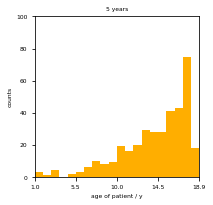

In [14]:
# Descriptive Statistics.
X_final_.describe(percentiles=[0.05,0.5,0.95], include='all')

# Age of Patient at First Dialysis.
fig = plt.figure(figsize=(2.95,2.95))
ax = fig.add_subplot(111)
plt.title("5 years")
ax.hist(X_final_['age of patient'], bins=20, stacked=True, color=plt.cm.Wistia(160),density=False, alpha=1.0)
ax.set_xlabel('age of patient / y')
#ax.set_ylabel(r"density / "+"("+lab_dict.loc[feature_name.upper()].values[0].lower()+r")$^{-1}$")
ax.set_ylabel("counts")
ax.set_xlim(np.round(np.min(X_final_['age of patient']),2), np.round(np.max(X_final_['age of patient']),2))
ax.set_xticks(np.linspace(np.round(np.min(X_final_['age of patient']),2), np.round(np.max(X_final_['age of patient']),2),5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set_ylim(0,100)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.savefig('./figures/histograms/ageofpatient',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.savefig('./figures/histograms/ageofpatient',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight',format='pdf')
plt.show()

In [15]:
# Random Forest Grid Search.
forest_clf = RandomForestClassifier(n_estimators=1000,max_depth=None,max_leaf_nodes=None,class_weight='balanced_subsample',oob_score=True,n_jobs=-1,random_state=0) # Define classifier to optimize.
parameters = {'max_leaf_nodes':np.linspace(2,10,9,dtype='int')} # Define grid. 
clf = RandomizedSearchCV(forest_clf, parameters, n_iter=50, cv=3,iid=False, scoring='recall',n_jobs=-1) # Balanced accuracy as performance measure.
clf.fit(X_final, y_final) # Train/optimize classifier.

# Feature Selection.
forest = clf.best_estimator_ # Retrieve best hyperparameters.
forest.fit(X_final, y_final) # Fit.
importances = forest.feature_importances_ # Retrieve feature importances.
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
print("The maximum number of leaf nodes is:",clf.best_estimator_.max_leaf_nodes)

The maximum number of leaf nodes is: 3


feature ranking:
1. feature 48 (0.080633) -> albumin
2. feature 101 (0.070115) -> age of patient
3. feature 73 (0.064899) -> ldh total
4. feature 74 (0.056200) -> lymphocytes
5. feature 87 (0.048554) -> rdw
6. feature 69 (0.047677) -> hemoglobin
7. feature 68 (0.045877) -> hematocrit
8. feature 37 (0.039420) -> postsittingsystolicbp
9. feature 86 (0.037766) -> rbc
10. feature 80 (0.036925) -> neutrophils
11. feature 104 (0.034706) -> z-scored weight
12. feature 66 (0.033405) -> hct calc (hgbx3)
13. feature 36 (0.029162) -> postsittingdiastolicbp
14. feature 34 (0.028522) -> lowestdiastolicbp
15. feature 61 (0.026313) -> creatinine
16. feature 100 (0.024466) -> spkt/v total
17. feature 47 (0.022371) -> a/g ratio
18. feature 35 (0.018785) -> lowestsystolicbp
19. feature 102 (0.016273) -> ufr
20. feature 103 (0.015629) -> iwg
21. feature 64 (0.013626) -> eosinophils
22. feature 70 (0.012633) -> iron
23. feature 72 (0.012397) -> kt/v prescribed
24. feature 84 (0.010810) -> protein total
25

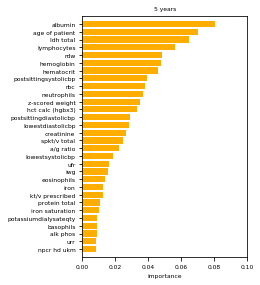

The test set accuracy (from out-of-bag samples) is: 0.8319559228650137
The sum of importance of the 30 most important features is: 0.8804392616045172


In [16]:
# Analyze Feature Importance.
n_f = 30 # Amount of Desired Features.
sorted_feature_names = []

# Print the Feature Ranking.
print("feature ranking:")
for f in range(n_f):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]),'->',feature_names[indices[f]])
    sorted_feature_names.append(feature_names[indices[f]])

# Plot the Feature Importances of the Forest.
plt.figure(figsize=(2.95,1.5*2.95))
plt.title("5 years")
plt.barh(range(n_f), importances[indices[0:n_f][::-1]],color=plt.cm.Wistia(160),ecolor=plt.cm.Wistia(160), xerr=None, align="center",alpha=1.0)
#plt.yticks(range(n_f), indices[0:n_f][::-1],rotation=0)
plt.yticks(range(n_f), reversed(sorted_feature_names),rotation=0)
plt.ylim([-1, n_f])
plt.xlim([0, 0.10])
plt.xlabel('importance')
plt.savefig('./figures/feature_importance',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.savefig('./figures/feature_importance',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight',format='pdf')
plt.show()

print('The test set accuracy (from out-of-bag samples) is:',forest.oob_score_)
print('The sum of importance of the',n_f,'most important features is:',np.sum(importances[indices[0:n_f]]))

In [17]:
# Feature Selection and Model Reduction

max_features = 20
reduced_classifier = SelectFromModel(forest,threshold=-np.inf,max_features=max_features,prefit=True) # Select best features.
selected_features = reduced_classifier.get_support(indices=True) # Retrieve indices of corresponding columns.
X_new = X_final_.iloc[:,selected_features] # Retrieve new matrix.
X_new.head(n=10) # Print new matrix.

,lowestdiastolicbp,lowestsystolicbp,postsittingdiastolicbp,postsittingsystolicbp,a/g ratio,albumin,creatinine,hct calc (hgbx3),hematocrit,hemoglobin,ldh total,lymphocytes,neutrophils,rbc,rdw,spkt/v total,age of patient,ufr,iwg,z-scored weight
PatientIdentifier,,,,,,,,,,,,,,,,,,,,
303,71.171717,127.151515,79.292929,150.606061,1.400000,4.218182,15.650000,34.871429,35.542857,11.623810,187.125000,25.222222,64.044444,3.934444,15.817169,1.444000,16.106849,9.432996,1.365876,3.756692
7164,77.910959,135.787671,81.917808,149.034247,0.983333,3.542857,13.900000,34.400000,38.057143,11.466667,219.333333,32.357143,52.200000,4.108571,15.817169,1.251111,18.273973,10.115401,1.351757,1.614806
26066,77.250000,131.250000,88.866667,157.466667,1.300000,4.200000,9.200000,30.000000,30.466667,10.000000,258.000000,13.400000,75.200000,3.270000,15.817169,2.160000,15.665753,4.643106,0.530000,0.618351
35241,68.896552,119.551724,78.844828,138.534483,0.800000,3.400000,10.400000,34.333333,35.322222,11.444444,298.000000,27.763054,61.046361,3.713728,15.817169,1.273333,17.112329,10.271616,1.206199,-0.610073
41641,69.718894,130.859447,78.020737,148.797235,1.340000,4.080000,10.660000,35.343750,31.220000,11.781250,170.000000,22.420000,62.600000,3.528000,15.817169,1.886000,16.868493,16.824223,2.008939,-0.413689
232309,61.037975,112.556962,66.392405,129.822785,1.520000,4.200000,7.420000,32.900000,31.916667,10.966667,179.600000,30.620000,61.480000,3.678000,15.817169,1.532500,16.813699,7.073579,0.705635,0.672993
233983,68.317241,109.551724,74.227586,132.165517,1.125000,3.545161,13.833333,31.959740,35.340000,10.653247,224.925926,13.744444,80.100000,3.878519,17.780769,1.748000,17.457534,12.555715,1.262086,-0.366958
240301,87.066667,135.133333,94.133333,155.466667,1.225000,3.400000,5.150000,27.960000,27.940000,9.320000,272.250000,27.625000,58.650000,2.827500,15.817169,1.576667,16.936986,10.628397,1.043771,-2.196308
243987,86.114286,128.414286,96.761194,145.805970,1.016667,3.700000,8.125000,30.688235,31.470588,10.229412,292.250000,21.560000,63.400000,3.580000,15.817169,2.240000,11.619178,20.693241,2.208535,-1.979751


In [18]:
# Random Forest Grid Search.
forest_clf_ = RandomForestClassifier(n_estimators=1000,max_depth=None,max_leaf_nodes=None,class_weight='balanced_subsample',oob_score=True,n_jobs=-1,random_state=0) # Define classifier to optimize.
clf_ = RandomizedSearchCV(forest_clf_, parameters, n_iter=50, cv=3,iid=False, scoring='recall',n_jobs=-1) # Balanced accuracy as performance measure.
clf_.fit(X_new, y_final) # Train/optimize classifier.

# Feature Selection.
forest_ = clf_.best_estimator_ # Retrieve best hyperparameters.
forest_.fit(X_new, y_final) # Fit.
print("The maximum number of leaf nodes is:",clf_.best_estimator_.max_leaf_nodes)
print('The test set accuracy (from out-of-bag samples) is:',forest_.oob_score_)

The maximum number of leaf nodes is: 3
The test set accuracy (from out-of-bag samples) is: 0.8126721763085399


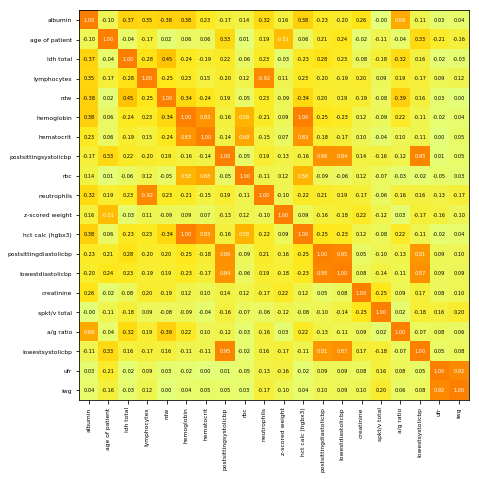

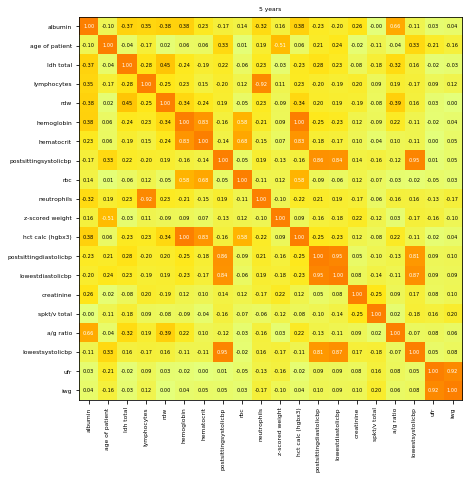

In [19]:
# Check for Linear Relationships Between Features.

# Calculate Covariance Matrix.
rho, pval = sp.stats.spearmanr(X_new[sorted_feature_names[:max_features]])
sigma = rho

fig, ax = plt.subplots(figsize=(2.25*2.95,2.25*2.95))
im = ax.imshow(np.abs(sigma),cmap=plt.cm.Wistia)

# We want to show all ticks...
ax.set_xticks(np.arange(len(list(X_new))))
ax.set_yticks(np.arange(len(list(X_new))))
# ... and label them with the respective list entries
ax.set_xticklabels(sorted_feature_names[:max_features])
ax.set_yticklabels(sorted_feature_names[:max_features])

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = sigma.max() / 2.
for i in range(sigma.shape[0]):
    for j in range(sigma.shape[1]):
        ax.text(j, i, format(sigma[i,j], fmt), fontsize=5,ha='center', va='center',color='white' if np.abs(sigma[i,j]) > thresh else 'black')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha='center',rotation_mode='default')

fig.tight_layout()
plt.savefig('./figures/correlations',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.savefig('./figures/correlations',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight',format='pdf')
plt.show()

fig, ax = plt.subplots(figsize=(2.25*2.95,2.25*2.95))
plt.title("5 years")
im = ax.imshow(np.abs(sigma),cmap=plt.cm.Wistia)

# We want to show all ticks...
ax.set_xticks(np.arange(len(list(X_new))))
ax.set_yticks(np.arange(len(list(X_new))))
# ... and label them with the respective list entries
ax.set_xticklabels(sorted_feature_names[:max_features])
ax.set_yticklabels(sorted_feature_names[:max_features])

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = sigma.max() / 2.
for i in range(sigma.shape[0]):
    for j in range(sigma.shape[1]):
        ax.text(j, i, format(sigma[i,j], fmt), fontsize=5,ha='center', va='center',color='white' if np.abs(sigma[i,j]) > thresh else 'black')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha='center',rotation_mode='default')

fig.tight_layout()
plt.savefig('./figures/correlations_app',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.savefig('./figures/correlations_app',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight',format='pdf')
plt.show()

In [20]:
# Remove Redundant Features.

# Find Features to Remove.
#threshold = 0.7 # Threshold of correlation to decide if feature has to be dropped.
#removable_features = [] # Initialize list.
#for i in range(1,sigma.shape[0]): # Loop over all rows.
    #for j in range(0,i): # Loop over all columns.
        #if np.abs(sigma[i,j]) >= threshold: # Check if threshold is reached.
            #if sorted_feature_names[i] not in removable_features: # Check if feature is not already in list.
                #removable_features.append(sorted_feature_names[i]) # Append to list.

removable_features = ['hematocrit','hct calc (hgbx3)','neutrophils','lowestsystolicbp','lowestdiastolicbp','postsittingdiastolicbp','age of patient','iwg']
X_new_ = X_new.drop(columns=removable_features) # Drop removable features.
# X_new_ = X_new_.drop(columns='age of patient') # Remove age of patient since it is a skewed distribution.

# Random Forest Grid Search.
forest_clf__ = RandomForestClassifier(n_estimators=1000,max_depth=None,max_leaf_nodes=None,class_weight='balanced_subsample',oob_score=True,n_jobs=-1,random_state=0) # Define classifier to optimize.
clf__ = RandomizedSearchCV(forest_clf__, parameters, n_iter=50, cv=3,iid=False, scoring='recall',n_jobs=-1) # Balanced accuracy as performance measure.
clf__.fit(X_new_, y_final) # Train/optimize classifier.

# Feature Selection.
forest__ = clf__.best_estimator_ # Retrieve best hyperparameters.
forest__.fit(X_new_, y_final) # Fit.
print("The maximum number of leaf nodes is:",clf__.best_estimator_.max_leaf_nodes)
print('The test set accuracy (from out-of-bag samples) is:',forest__.oob_score_)

The maximum number of leaf nodes is: 3
The test set accuracy (from out-of-bag samples) is: 0.8016528925619835


feature ranking:
1. feature 2 (0.205008) -> albumin
2. feature 5 (0.135488) -> ldh total
3. feature 6 (0.099354) -> lymphocytes
4. feature 7 (0.092534) -> rbc
5. feature 8 (0.089604) -> rdw
6. feature 4 (0.079986) -> hemoglobin
7. feature 11 (0.075980) -> z-scored weight
8. feature 0 (0.063411) -> postsittingsystolicbp
9. feature 1 (0.042115) -> a/g ratio
10. feature 10 (0.039952) -> ufr
11. feature 3 (0.038809) -> creatinine
12. feature 9 (0.037759) -> spkt/v total


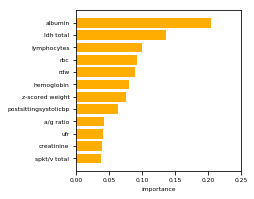

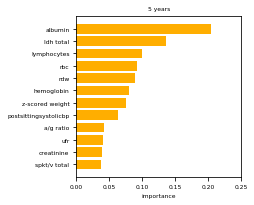

In [21]:
# Reanalyze Feature Importances.
feature_names_ = list(X_new_)
importances_ = forest__.feature_importances_ # Retrieve feature importances.
std_ = np.std([tree.feature_importances_ for tree in forest__.estimators_],axis=0)
indices_ = np.argsort(importances_)[::-1]

# Analyze Feature Importance.
n_f = len(list(X_new_)) # Amount of Desired Features.
sorted_feature_names_ = []

# Print the Feature Ranking.
print("feature ranking:")
for f in range(n_f):
    print("%d. feature %d (%f)" % (f + 1, indices_[f], importances_[indices_[f]]),'->',feature_names_[indices_[f]])
    sorted_feature_names_.append(feature_names_[indices_[f]])

# Plot the Feature Importances of the Forest.
plt.figure(figsize=(2.95,2.95))
plt.barh(range(n_f), importances_[indices_[0:n_f][::-1]],color=plt.cm.Wistia(160),ecolor=plt.cm.Wistia(160), xerr=None, align="center",alpha=1.0)
plt.yticks(range(n_f), reversed(sorted_feature_names_),rotation=0)
plt.xticks((0,0.05,0.1,0.15,0.2,0.25))
plt.ylim([-1, n_f])
plt.xlim([0, 0.25])
plt.xlabel('importance')
plt.savefig('./figures/feature_importance_final',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.savefig('./figures/feature_importance_final',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight',format='pdf')
plt.show()

# Plot the Feature Importances of the Forest.
plt.figure(figsize=(2.95,2.95))
plt.title("5 years")
plt.barh(range(n_f), importances_[indices_[0:n_f][::-1]],color=plt.cm.Wistia(160),ecolor=plt.cm.Wistia(160), xerr=None, align="center",alpha=1.0)
plt.yticks(range(n_f), reversed(sorted_feature_names_),rotation=0)
plt.xticks((0,0.05,0.1,0.15,0.2,0.25))
plt.ylim([-1, n_f])
plt.xlim([0, 0.25])
plt.xlabel('importance')
plt.savefig('./figures/feature_importance_final_app',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.savefig('./figures/feature_importance_final_app',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight',format='pdf')
plt.show()

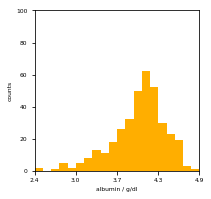

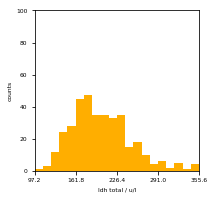

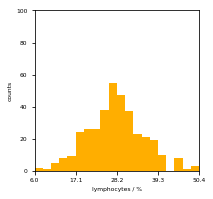

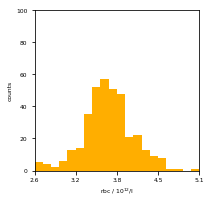

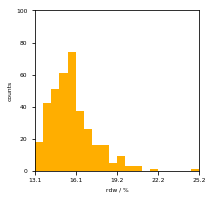

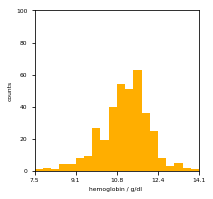

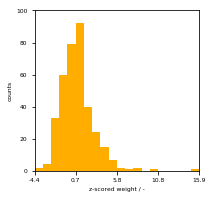

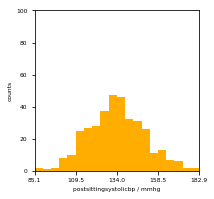

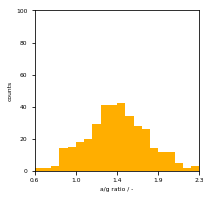

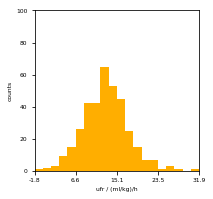

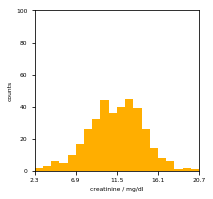

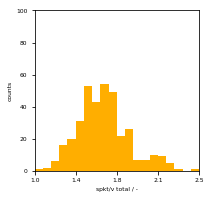

In [22]:
# Histogram of the Most Important Features
for i,feature_name in enumerate(sorted_feature_names_):
    fig = plt.figure(figsize=(2.95,2.95))
    ax = fig.add_subplot(111)
    ax.hist(X_new_[feature_name], bins=20, stacked=True, color=plt.cm.Wistia(160),density=False, alpha=1.0)
    ax.set_xlabel(feature_name+" / "+lab_dict.loc[feature_name.upper()].values[0].lower())
    #ax.set_ylabel(r"density / "+"("+lab_dict.loc[feature_name.upper()].values[0].lower()+r")$^{-1}$")
    ax.set_ylabel("counts")
    ax.set_xlim(np.round(np.min(X_new_[feature_name]),2), np.round(np.max(X_new_[feature_name]),2))
    ax.set_xticks(np.linspace(np.round(np.min(X_new_[feature_name]),2), np.round(np.max(X_new_[feature_name]),2),5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_ylim(0,100)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    plt.savefig('./figures/histograms/histogram'+str(i),dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
    plt.savefig('./figures/histograms/histogram'+str(i),dpi=900,transparent=True,orientation='landscape',bbox_inches='tight',format='pdf')
    plt.show()

In [23]:
# Model Interpretation.
interpreter_ = Interpretation(X_new_, feature_names=list(X_new_)) # Start interpretation instance.
model_ = InMemoryModel(forest__.predict_proba, examples=X_new_, target_names=['alive', 'death']) # Open model instance.

pdp_ = {} # Define dictionary.

for i,element in enumerate(sorted_feature_names_): # Loop over all relevant features.
    pdp_[element] = interpreter_.partial_dependence.partial_dependence([element],model_,grid_resolution=50,progressbar=False) # Calculate the sensitivity.

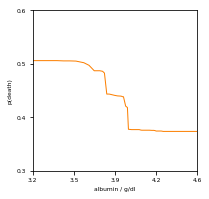

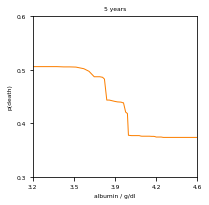

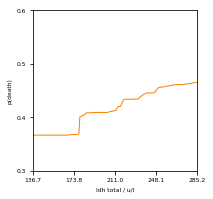

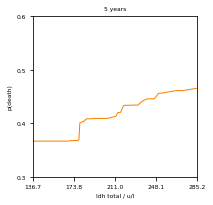

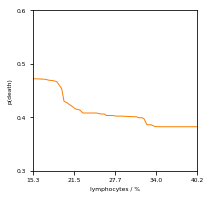

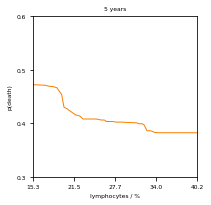

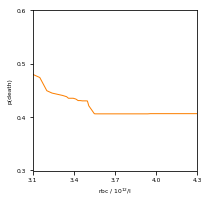

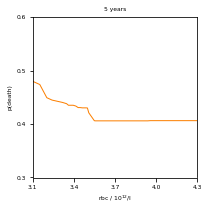

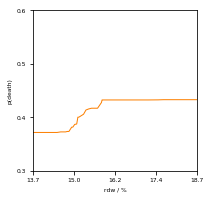

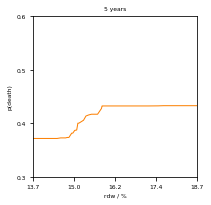

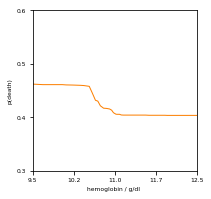

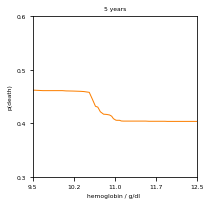

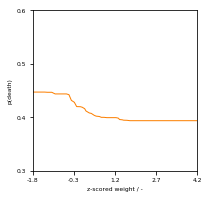

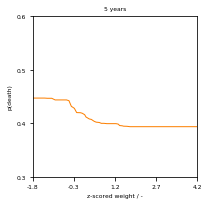

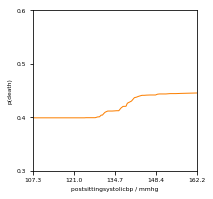

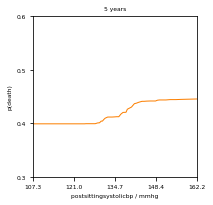

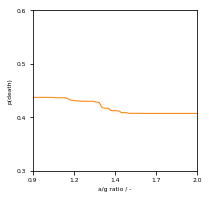

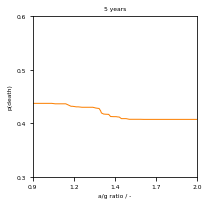

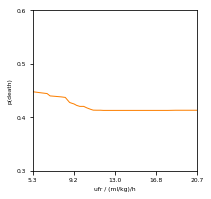

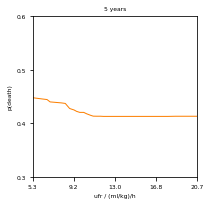

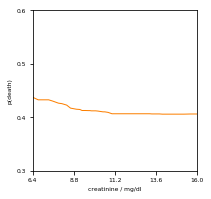

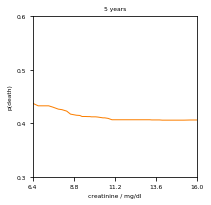

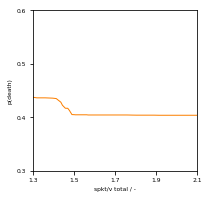

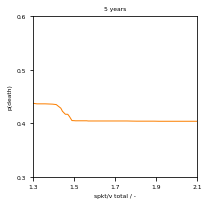

In [24]:
# Single Partial Dependence Plots.
max_subplots = len(list(X_new_))

for i,element in enumerate(sorted_feature_names_[0:(max_subplots)]): # Loop over all relevant features.
    fig,ax = plt.subplots(1,1,figsize=(2.95,2.95))
    ax.plot(pdp_[element][element],pdp_[element]['death'],color=plt.cm.Wistia(255))
    # ax.fill_between(pdp_[element][element], pdp_[element]['death']-(pdp_[element]['sd_prediction'])/2,pdp_[element]['death']+(pdp_[element]['sd_prediction'])/2, alpha=0.1,color=plt.cm.Wistia(255)) # sd_estimate: the variance of the partial dependence estimates, sd_prediction: the variances of the predictions at the given point
    ax.set_xlabel(element+' / '+lab_dict.loc[element.upper()].values[0].lower())
    ax.set_ylabel('p(death)')
    # ax.legend(loc=0,frameon=False)
    ax.set_xlim(np.round(np.min(pdp_[element][element]),2), np.round(np.max(pdp_[element][element]),2))
    ax.set_xticks(np.linspace(np.round(np.min(pdp_[element][element]),2), np.round(np.max(pdp_[element][element]),2),5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_ylim(0.3,0.6)
    ax.set_yticks((0.3,0.4,0.5,0.6))
    plt.savefig('./figures/pdp2/sensitivity_analysis'+str(i),dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
    plt.savefig('./figures/pdp2/sensitivity_analysis'+str(i),dpi=900,transparent=True,orientation='landscape',bbox_inches='tight',format='pdf')
    
    fig,ax = plt.subplots(1,1,figsize=(2.95,2.95))
    plt.title("5 years")
    ax.plot(pdp_[element][element],pdp_[element]['death'],color=plt.cm.Wistia(255))
    #ax.fill_between(pdp_[element][element], pdp_[element]['death']-(pdp_[element]['sd_prediction'])/2,pdp_[element]['death']+(pdp_[element]['sd_prediction'])/2, alpha=0.1,color=plt.cm.Wistia(255)) # sd_estimate: the variance of the partial dependence estimates, sd_prediction: the variances of the predictions at the given point
    ax.set_xlabel(element+' / '+lab_dict.loc[element.upper()].values[0].lower())
    ax.set_ylabel('p(death)')
    # ax.legend(loc=0,frameon=False)
    ax.set_xlim(np.round(np.min(pdp_[element][element]),2), np.round(np.max(pdp_[element][element]),2))
    ax.set_xticks(np.linspace(np.round(np.min(pdp_[element][element]),2), np.round(np.max(pdp_[element][element]),2),5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_ylim(0.3,0.6)
    ax.set_yticks((0.3,0.4,0.5,0.6))
    plt.savefig('./figures/pdp2/sensitivity_analysis_app'+str(i),dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
    plt.savefig('./figures/pdp2/sensitivity_analysis_app'+str(i),dpi=900,transparent=True,orientation='landscape',bbox_inches='tight',format='pdf')

In [44]:
# 2-D Partial Dependence Plot.
element1, element2 = 'z-scored weight', 'spkt/v total'
resolution = 20
pd_2D = interpreter_.partial_dependence.partial_dependence([element1,element2],model_,grid_resolution=resolution,progressbar=False) # Calculate the sensitivity.

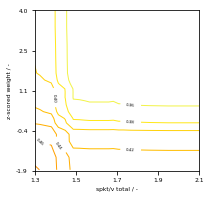

In [47]:
# Draw 2D Partial Dependence Plot.
fig,ax = plt.subplots(1,1,figsize=(2.95,2.95))
cs = ax.contour(np.unique(pd_2D[element2]),np.unique(pd_2D[element1]),np.reshape(pd_2D['death'].values,(resolution,resolution)), cmap=plt.cm.Wistia)
plt.clabel(cs,fontsize=4,colors='k',fmt='%1.2f')
#levels = np.linspace(np.round(np.min(pd_2D['death']),2), np.round(np.max(pd_2D['death']),2),8)
#cs = ax1.contourf(np.unique(pd_2D[element2]),np.unique(pd_2D[element1]),np.reshape(pd_2D['death'].values,(resolution,resolution)),50, cmap=plt.cm.Wistia)
#cbar = plt.colorbar(cs, cax=ax2)
#cbar.set_label('p(death)', rotation=90,fontsize=6)
#cbar.set_ticks(np.arange(np.round(np.min(pd_2D['death']),2), np.round(np.max(pd_2D['death']),2),0.02))
#cbar.set_ticklabels(np.arange(np.round(np.min(pd_2D['death']),2), np.round(np.max(pd_2D['death']),2),0.02))
#cbar.ax.tick_params(labelsize=6) 
ax.set_xlabel(element2+' / -')
ax.set_ylabel(element1+' / -')
ax.set_xlim(np.round(np.min(pd_2D[element2]),1), np.round(np.max(pd_2D[element2]),1))
ax.set_xticks(np.linspace(np.round(np.min(pd_2D[element2]),1), np.round(np.max(pd_2D[element2]),1),5))
ax.set_ylim(np.round(np.min(pd_2D[element1]),1), np.round(np.max(pd_2D[element1]),1))
ax.set_yticks(np.linspace(np.round(np.min(pd_2D[element1]),1), np.round(np.max(pd_2D[element1]),1),5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.savefig('./figures/pdp2/sensitivity_analysis_2D',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.savefig('./figures/pdp2/sensitivity_analysis_2D',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight',format='pdf')

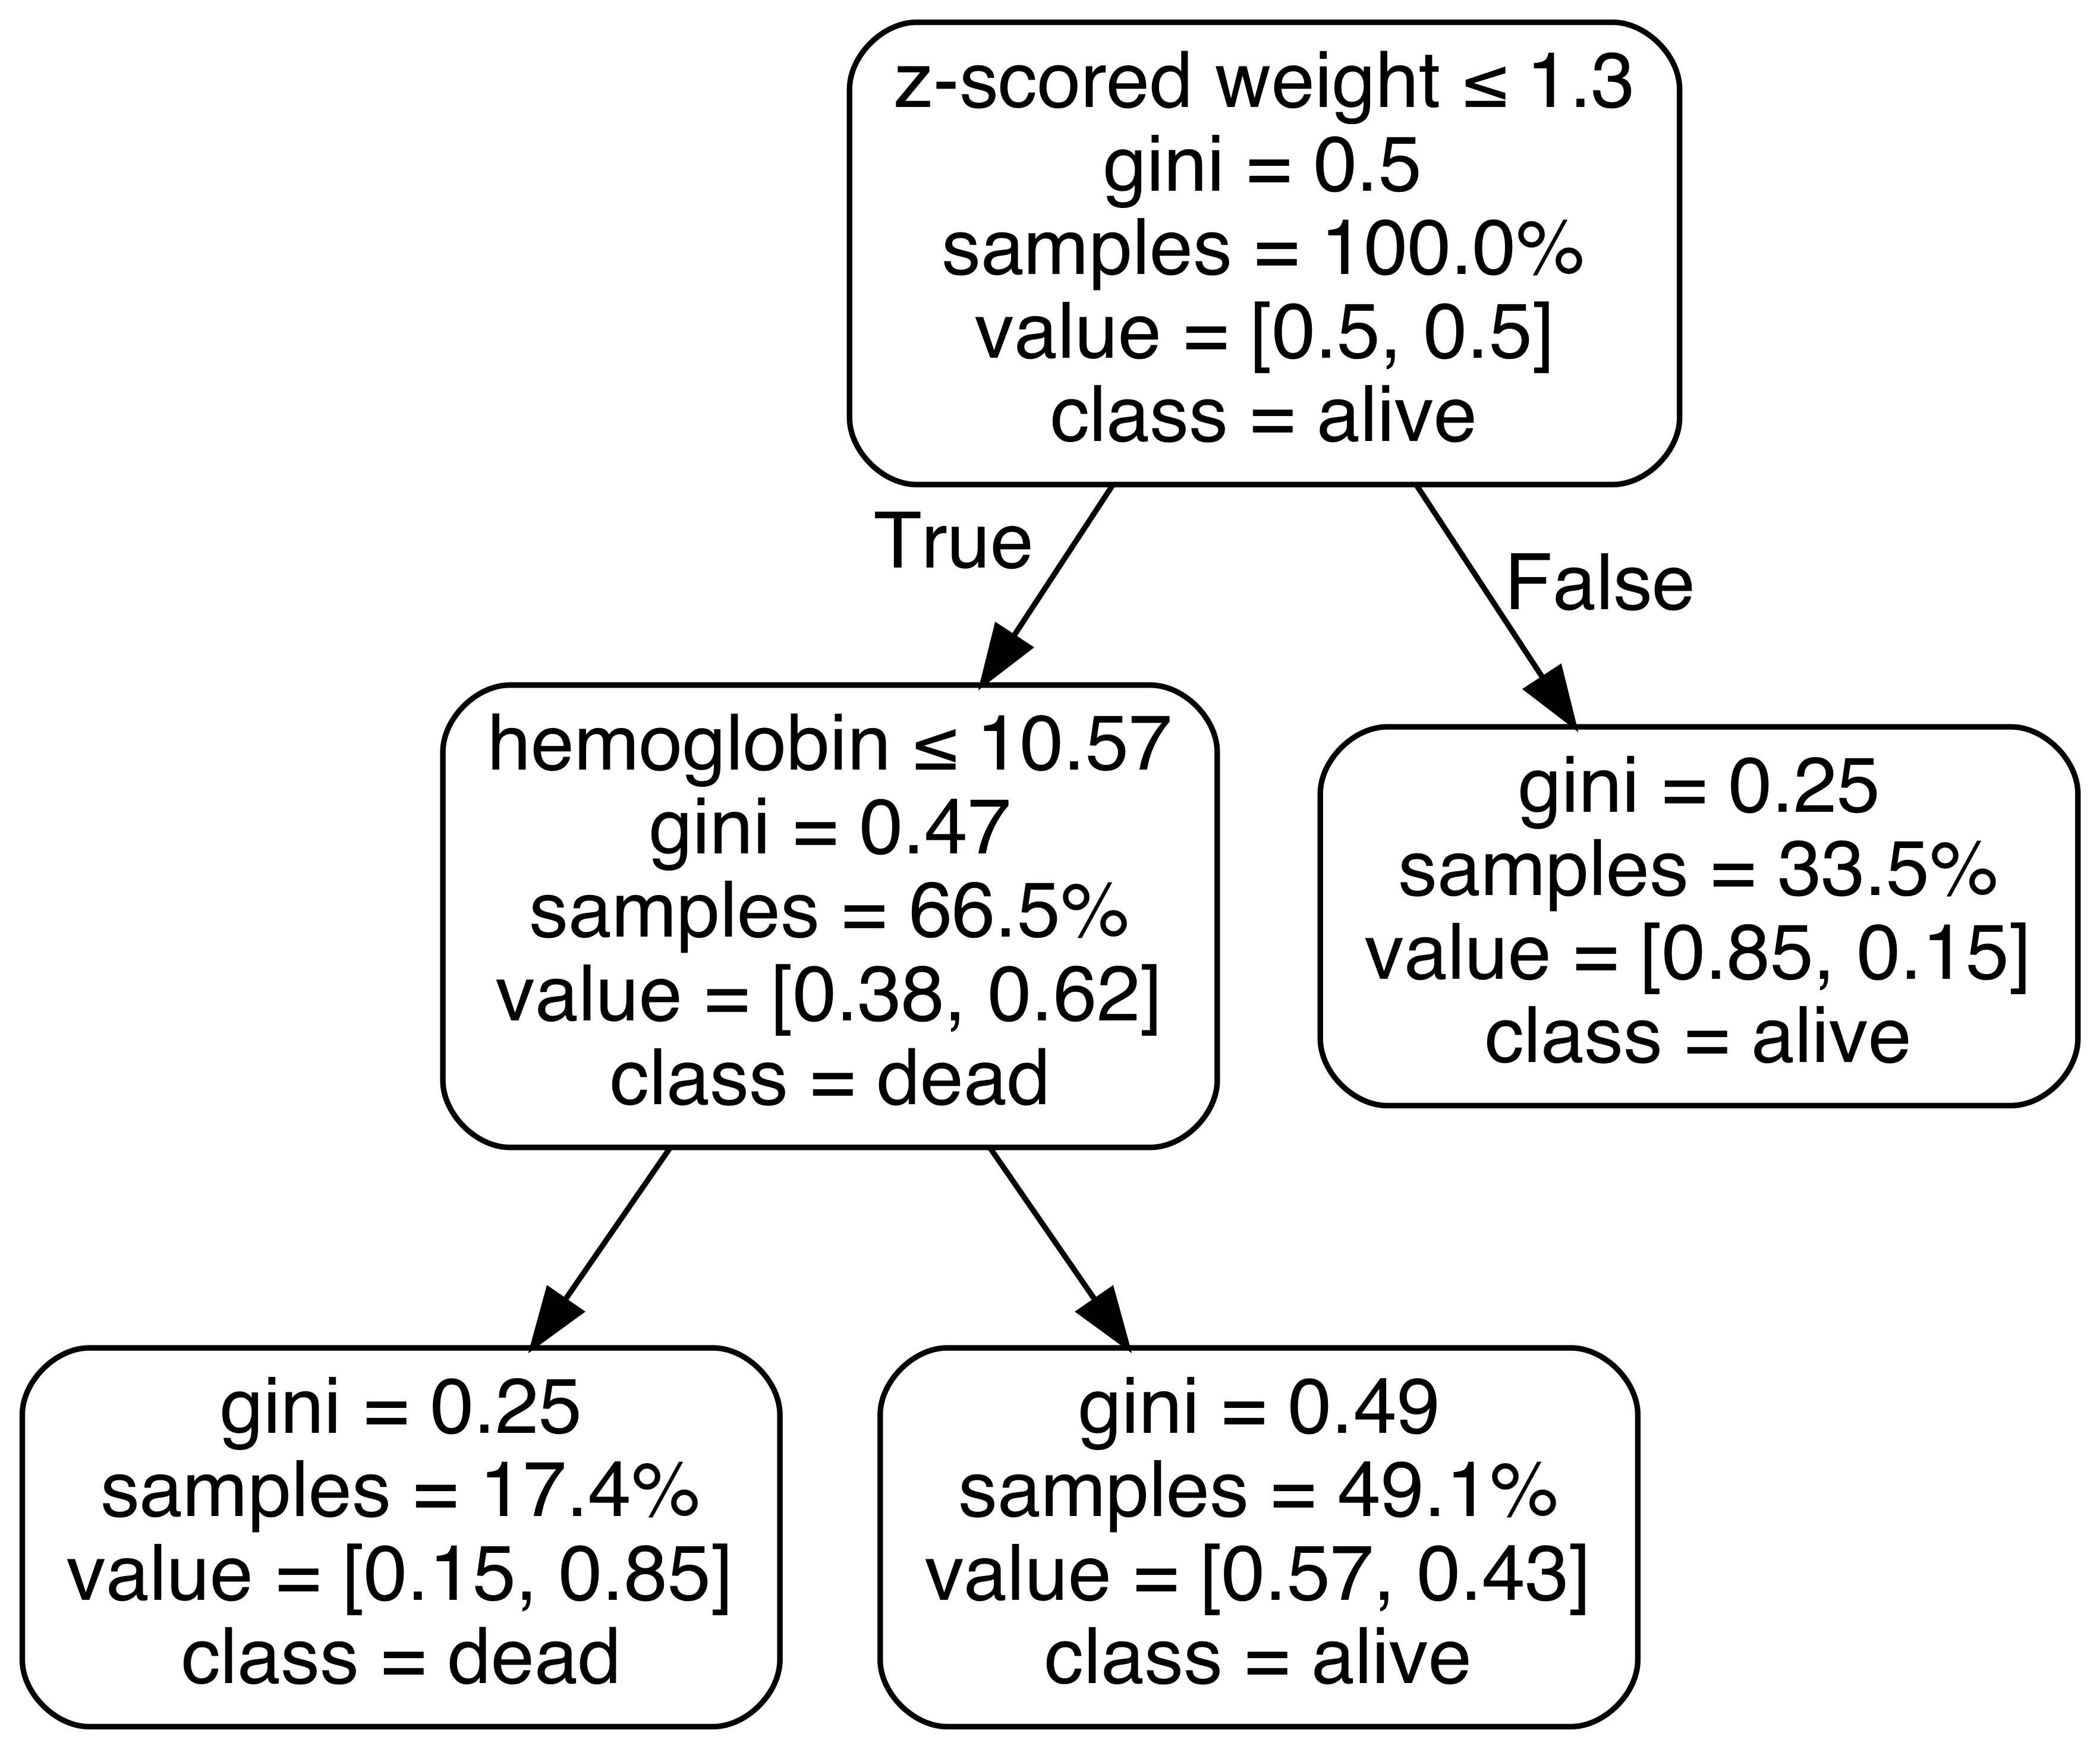

In [25]:
# Visualize an Example Tree.

dot_data = StringIO()  
tree.export_graphviz(forest__.estimators_[0], out_file=dot_data,filled=False,feature_names=list(X_new_),class_names=class_names,rounded=True,precision=2,special_characters=True,leaves_parallel=False,rotate=False,proportion=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.set('dpi','1200')
graph.set('fontsize','6')
graph.set('size','2.95,2.95')
graph.write_png('./figures/tree.png')
Image(graph.create_png())

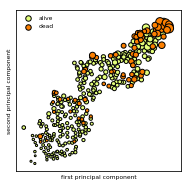

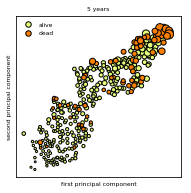

In [26]:
# Dimensionality Reduction.
#dim_red = PCA(n_components=2)
#dim_red = NMF(n_components=2)
dim_red = TSNE(n_components=2,perplexity=50)
Y = dim_red.fit_transform(X_final_[list(X_new_)])
# print('explained variance ratio (first two components): %s' % str(100*dim_red.explained_variance_ratio_),'%')

# Plot.
fig = plt.figure(figsize=(2.95,2.95))
ax = fig.add_subplot(111)
ax.scatter(Y[y_final==0, 0], Y[y_final==0, 1], color=plt.cm.Wistia(0), s=30*((((X_final_['ldh total'])/(np.max(X_final_['ldh total'])))/((X_final_['albumin'])/(np.max(X_final_['albumin']))))**(2))[y_final==0], edgecolors='k', alpha=1.0,label='alive')
ax.scatter(Y[y_final==1, 0], Y[y_final==1, 1], color=plt.cm.Wistia(255), s=30*((((X_final_['ldh total'])/(np.max(X_final_['ldh total'])))/((X_final_['albumin'])/(np.max(X_final_['albumin']))))**(2))[y_final==1], edgecolors='k', alpha=1.0,label='dead')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
lgd = plt.legend(frameon=False)
lgd.legendHandles[0]._sizes = [30]
lgd.legendHandles[1]._sizes = [30]
ax.set_xticks(())
ax.set_yticks(())
plt.savefig('./figures/dr_final_analysis',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.savefig('./figures/dr_final_analysis',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight',format='pdf')
plt.show()

fig = plt.figure(figsize=(2.95,2.95))
ax = fig.add_subplot(111)
plt.title("5 years")
ax.scatter(Y[y_final==0, 0], Y[y_final==0, 1], color=plt.cm.Wistia(0), s=30*((((X_final_['ldh total'])/(np.max(X_final_['ldh total'])))/((X_final_['albumin'])/(np.max(X_final_['albumin']))))**(2))[y_final==0], edgecolors='k', alpha=1.0,label='alive')
ax.scatter(Y[y_final==1, 0], Y[y_final==1, 1], color=plt.cm.Wistia(255), s=30*((((X_final_['ldh total'])/(np.max(X_final_['ldh total'])))/((X_final_['albumin'])/(np.max(X_final_['albumin']))))**(2))[y_final==1], edgecolors='k', alpha=1.0,label='dead')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
lgd = plt.legend(frameon=False)
lgd.legendHandles[0]._sizes = [30]
lgd.legendHandles[1]._sizes = [30]
ax.set_xticks(())
ax.set_yticks(())
plt.savefig('./figures/dr_final_analysis_app',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.savefig('./figures/dr_final_analysis_app',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight',format='pdf')
plt.show()

In [27]:
# ROC Curve.

y_true = y_final
y_pred = forest__.predict_proba(X_new_)[:,1]
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_pred, pos_label=None, sample_weight=None, drop_intermediate=True)
roc = roc_auc_score(y_true, forest__.predict(X_new_),average='weighted')

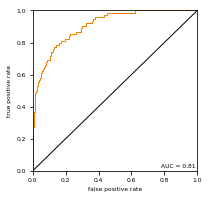

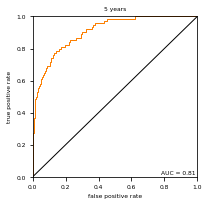

In [28]:
# Plot.
fig = plt.figure(figsize=(2.95,2.95))
ax = fig.add_subplot(111)
ax.plot(fpr, tpr, color=plt.cm.Wistia(255))
ax.plot(np.linspace(0,1,5),np.linspace(0,1,5),'-',color='k')
ax.text(0.99, 0.01, 'AUC = %.2f' %(roc),verticalalignment='bottom', horizontalalignment='right',color='black', fontsize=6)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
plt.savefig('./figures/ROC_curve',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.savefig('./figures/ROC_curve',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight',format='pdf')
plt.show()

fig = plt.figure(figsize=(2.95,2.95))
ax = fig.add_subplot(111)
plt.title("5 years")
ax.plot(fpr, tpr, color=plt.cm.Wistia(255))
ax.plot(np.linspace(0,1,5),np.linspace(0,1,5),'-',color='k')
ax.text(0.99, 0.01, 'AUC = %.2f' %(roc),verticalalignment='bottom', horizontalalignment='right',color='black', fontsize=6)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
plt.savefig('./figures/ROC_curve_app',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.savefig('./figures/ROC_curve_app',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight',format='pdf')
plt.show()

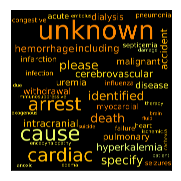

In [28]:
# Word Cloud for Reasons to Die.

corpus = (data_cohort['PatientCauseOfDeathDesc'].loc[X_0.index]).dropna().values

list_of_reasons = []
for item in corpus:
    list_of_reasons.append(' '.join(item.lower().split()[1:]))

f, ax = plt.subplots(1, 1,figsize=(2.95,2.95),sharex=True, sharey=True)
wordcloud = WordCloud(font_path="/anaconda3/fonts/DejaVuSans.ttf",max_font_size=800,max_words=100,background_color='black',colormap=plt.cm.Wistia,
                      width=5000,height=5000,mode='RGB',scale=1,collocations=False).generate(' '.join(list_of_reasons))
ax.imshow(wordcloud,interpolation='bilinear')
plt.xticks(())
plt.yticks(())
plt.savefig('./figures/word_cloud_death',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.savefig('./figures/word_cloud_death',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight',format='pdf')
plt.show()

In [35]:
# List of Features.
sorted_list_of_features = sorted(list(X_final_))
cohort_list = [item.lower() for item in list(data_cohort_)]
treatment_list = [item.lower() for item in list(data_treatment_)]
hospitalization_list = [item.lower() for item in list(data_hospitalization_)]
lab_list = [item.lower() for item in list(data_lab_)]

with open('list_of_features_extended.txt', 'w') as f:
    for item in sorted_list_of_features:
        if item in cohort_list:
            variable_type = "cohort property"
            data_type = "categorical"
        elif item in treatment_list:
            variable_type = "treatment parameter"
            data_type = "continuous"
        elif item in hospitalization_list:
            variable_type = "hospitalization reason"
            data_type = "continuous (ordinal)"
        elif item in lab_list:
            variable_type = "lab value"
            data_type = "continuous"
        else:
            variable_type = "-"
            data_type = "-"
        f.write("{}\n".format(item+r" & "+variable_type+" & "+data_type+r" & \\"))
f.close()